## Phosphorus Concentration and Sample Site Mapping

#### Code author: Elaine Czarnik

Code source referenced to create maps: https://dev.to/oscarleo/how-to-create-data-maps-of-the-united-states-with-matplotlib-p9i

In [578]:
# Import required libraries
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from matplotlib.patches import Patch, Circle

In [579]:
# Read in final dataset
usgs_GL_final = pd.read_csv('maps_dataset.csv')
usgs_GL_final.head()

CountyState  ActivityYear  ResultMeasureValue  \
0  Adams County-Illinois          2010            0.212773   
1  Adams County-Illinois          2011            0.083278   
2  Adams County-Illinois          2012            0.079962   
3  Adams County-Illinois          2013            0.088600   
4  Adams County-Illinois          2014            0.184000   

   ActivityLocation/LatitudeMeasure  ActivityLocation/LongitudeMeasure  
0                         40.055899                         -91.371083  
1                         40.007116                         -91.242255  
2                         40.069261                         -91.365847  
3                         39.970719                         -91.140114  
4                         40.023338                         -91.334644

In [580]:
# Get dataset shape
usgs_GL_final.shape

(5058, 5)

In [581]:
# Split State and County into two separate columns
usgs_GL_final['State'] = usgs_GL_final['CountyState'].apply(lambda x: x.split('-')[-1] if '-' in x else None)
usgs_GL_final['County'] = usgs_GL_final['CountyState'].apply(lambda x: '-'.join(x.split('-')[:-1]) if '-' in x else x)
usgs_GL_final.head()

CountyState  ActivityYear  ResultMeasureValue  \
0  Adams County-Illinois          2010            0.212773   
1  Adams County-Illinois          2011            0.083278   
2  Adams County-Illinois          2012            0.079962   
3  Adams County-Illinois          2013            0.088600   
4  Adams County-Illinois          2014            0.184000   

   ActivityLocation/LatitudeMeasure  ActivityLocation/LongitudeMeasure  \
0                         40.055899                         -91.371083   
1                         40.007116                         -91.242255   
2                         40.069261                         -91.365847   
3                         39.970719                         -91.140114   
4                         40.023338                         -91.334644   

      State        County  
0  Illinois  Adams County  
1  Illinois  Adams County  
2  Illinois  Adams County  
3  Illinois  Adams County  
4  Illinois  Adams County

In [582]:
# Get county counts
county_count = usgs_GL_final.groupby('State')['County'].nunique()
print(f'Total county count across Great Lakes states: {county_count.sum()}')
print(f'Number of counties by state: {county_count}')

Total county count across Great Lakes states: 624
Number of counties by state: State
Illinois        102
Indiana          72
Michigan         79
Minnesota        87
New York         60
Ohio             85
Pennsylvania     67
Wisconsin        72
Name: County, dtype: int64


In [583]:
# Remove "County" from the County column
usgs_GL_final['County'] = usgs_GL_final['County'].apply(lambda x: x.split()[0])
usgs_GL_final.head()

CountyState  ActivityYear  ResultMeasureValue  \
0  Adams County-Illinois          2010            0.212773   
1  Adams County-Illinois          2011            0.083278   
2  Adams County-Illinois          2012            0.079962   
3  Adams County-Illinois          2013            0.088600   
4  Adams County-Illinois          2014            0.184000   

   ActivityLocation/LatitudeMeasure  ActivityLocation/LongitudeMeasure  \
0                         40.055899                         -91.371083   
1                         40.007116                         -91.242255   
2                         40.069261                         -91.365847   
3                         39.970719                         -91.140114   
4                         40.023338                         -91.334644   

      State County  
0  Illinois  Adams  
1  Illinois  Adams  
2  Illinois  Adams  
3  Illinois  Adams  
4  Illinois  Adams

In [584]:
# Define create_color function
def create_color(county_df, data_breaks):
    """
    Assigns a color to each county based on its phosphorus level,
    using predefined thresholds and corresponding colors.

    Parameters
    ----------
    county_df: dataframe
            Dataframe of county shape file data
    data_breaks: list of tuples
        List of tuples containing threshold value (float),
        color hex code (str), and a label (str) for different phosphorus levels
    Return
    ------
    colors: list
         A list of hex color codes corresponding to each county's phosphorus level,
         determined by the `data_breaks` thresholds
    """
    colors = []
    for i, row in county_df.iterrows():
        for p, c, _ in data_breaks:
            if row.ResultMeasureValue >= p:
                colors.append(c)
                break
    return colors

In [585]:
# Define load_county_data function
def load_county_data():
    """
    Loads geographic data for counties in Great Lakes states from Census shapefiles.

    Return
    ------
    counties: geopandas.GeoDataFrame
        A GeoDataFrame containing geographic and boundary data for counties in the
        Great Lakes states (Illinois, Indiana, Michigan, Minnesota, New York, Ohio,
        Pennsylvania, and Wisconsin)
    """
    # Load and prepare geo-data
    counties = gpd.read_file("./cb_2018_us_county_500k/")
    # Grab counties in Great Lakes states shape data
    counties = counties[counties.STATEFP.isin(["17", "18", "26", "27", "36", "39", "42", "55"])]
    counties = counties.set_index("GEOID")
    return counties

In [586]:
# Define load_state_data function
def load_state_data():
    """
    Loads geographic data for Great Lakes states from Census shapefiles.

    Return
    ------
    states: geopandas.GeoDataFrame
        A GeoDataFrame containing geographic and boundary data for the Great Lakes states
    """
    states = gpd.read_file("./cb_2018_us_state_500k/")
    # Grab Great Lakes states shape data
    states = states[states.STATEFP.isin(["17", "18", "26", "27", "36", "39", "42", "55"])]
    return states

In [587]:
# Define add_legend function
def add_legend(data_breaks, edge_color, background_color):
    """
    Adds a legend to a map based on specified color breaks and labels

    Parameters
    ----------
    data_breaks: list of tuples
        List of tuples containing threshold value (float),
        color hex code (str), and a label (str) for different phosphorus levels
    edge_color: str
        Color code (as a hexcode) that defines the edge color of the patch in the legend
    background_color: str
        Color code (as a hexcode) that defines the background color of the legend
    """
    patches = [Patch(facecolor=c, edgecolor=edge_color, label=t) for _, c, t in data_breaks]

    leg = plt.legend(
        handles=patches,
        bbox_to_anchor=(0.5, -0.1), loc='center',
        ncol=10, fontsize=15, columnspacing=1,
        handlelength=1, handleheight=1,
        edgecolor=background_color,
        handletextpad=0.4
    )

In [588]:
# Define add_title function
def add_title(year):
    """
    Adds a title to a map based on a specified year

    Parameters
    ----------
    year: int
        The year of the phosphorus data to be visualized
    """
    plt.annotate(
        text=f"{year} Great Lakes Region Phosphorus Levels",
        xy=(0.5, 0.95), xycoords="axes fraction", fontsize=28, ha="center",
        fontweight="bold"
    )

In [589]:
# Define add_information function
def add_information():
    """
    Adds supplementary information, such as comments or footnotes, to a map
    """
    plt.annotate(
        "Total concentration of phosphorus in milligrams per liter",
        xy=(0.5, -0.15), xycoords="axes fraction", fontsize=12, ha="center",
        fontweight="normal"
    )
    plt.annotate(
        "Source: https://waterdata.usgs.gov/nwis/qw/",
        xy=(0.5, -0.22), xycoords="axes fraction", fontsize=12, ha="center",
        fontweight="normal"
    )

In [590]:
# Define create_map function
def create_map(dataframe, year, county_df, states_df):
    """
    Generate map of Great Lakes region based on a specified dataframe,
    year, county dataframe, and states dataframe

    Parameters
    ----------
    dataframe: pandas.DataFrame
        The dataframe of phosphorus sample data to be visualized
    year: int
        The year of the phosphorus data to be visualized
    county_df: geopandas.GeoDataFrame
        A GeoDataFrame containing geographic data for county boundaries within the
        Great Lakes regionA GeoDataFrame containing geographic and boundary data for counties in the
        Great Lakes states (Illinois, Indiana, Michigan, Minnesota, New York, Ohio,
        Pennsylvania, and Wisconsin)
    states_df: geopandas.GeoDataFrame
        A GeoDataFrame containing geographic and boundary data for the Great Lakes states
    """
    # Filter by year
    filtered_data = dataframe[dataframe['ActivityYear'] == year].copy()
    # Specify databreaks for phosphorus level coloring thresholds
    data_breaks = [
    (0.5, "#2C3D76", ">= 0.5 mg/L"),
    (0.3, "#618ABF", "0.3 to < 0.5 mg/L"),
    (0.1, "#82C490", "0.1 to < 0.3 mg/L"),
    (0, "#97D8C4", "< 0.1 mg/L"),
    (-1, "#FFFFFF", "No sample data available")
    ]
    # Select color for percentile splits for the mean phosphorus value
    filtered_data['Color'] = create_color(filtered_data, data_breaks)

    edge_color = "#30011E"
    background_color = "#fafafa"

    sns.set_style({
        "font.family": "serif",
        "figure.facecolor": background_color,
        "axes.facecolor": background_color,
    })

    # Set up empty STATEFP column in filtered_data
    filtered_data["STATEFP"] = None

     # Adding StateFP data to filtered_data
    for i, row in filtered_data.iterrows():
        filtered_data.at[i, "STATEFP"] = states_df[states_df["NAME"] == filtered_data.at[i, "State"]]["STATEFP"].iloc[0]

    # Merge county data with filtered_data
    county_df = county_df.merge(filtered_data[["Color", "STATEFP", "County"]], how="left", left_on=["STATEFP", "NAME"], right_on=["STATEFP", "County"])
    # Fill missing colors with the color white
    county_df['Color'] = county_df['Color'].fillna("#FFFFFF")

    ax = county_df.plot(edgecolor=edge_color + "55", color=county_df.Color, figsize=(20, 20))
    states_df.plot(ax=ax, edgecolor=edge_color, color="None", linewidth=1)

    add_legend(data_breaks, edge_color, background_color)
    add_information()
    add_title(year)

    plt.axis("off")
    plt.show()

In [591]:
# Load state and county datasets
county_df = load_county_data()
states_df = load_state_data()

### Generate County Phosphorus Level Maps for 2010 - 2022

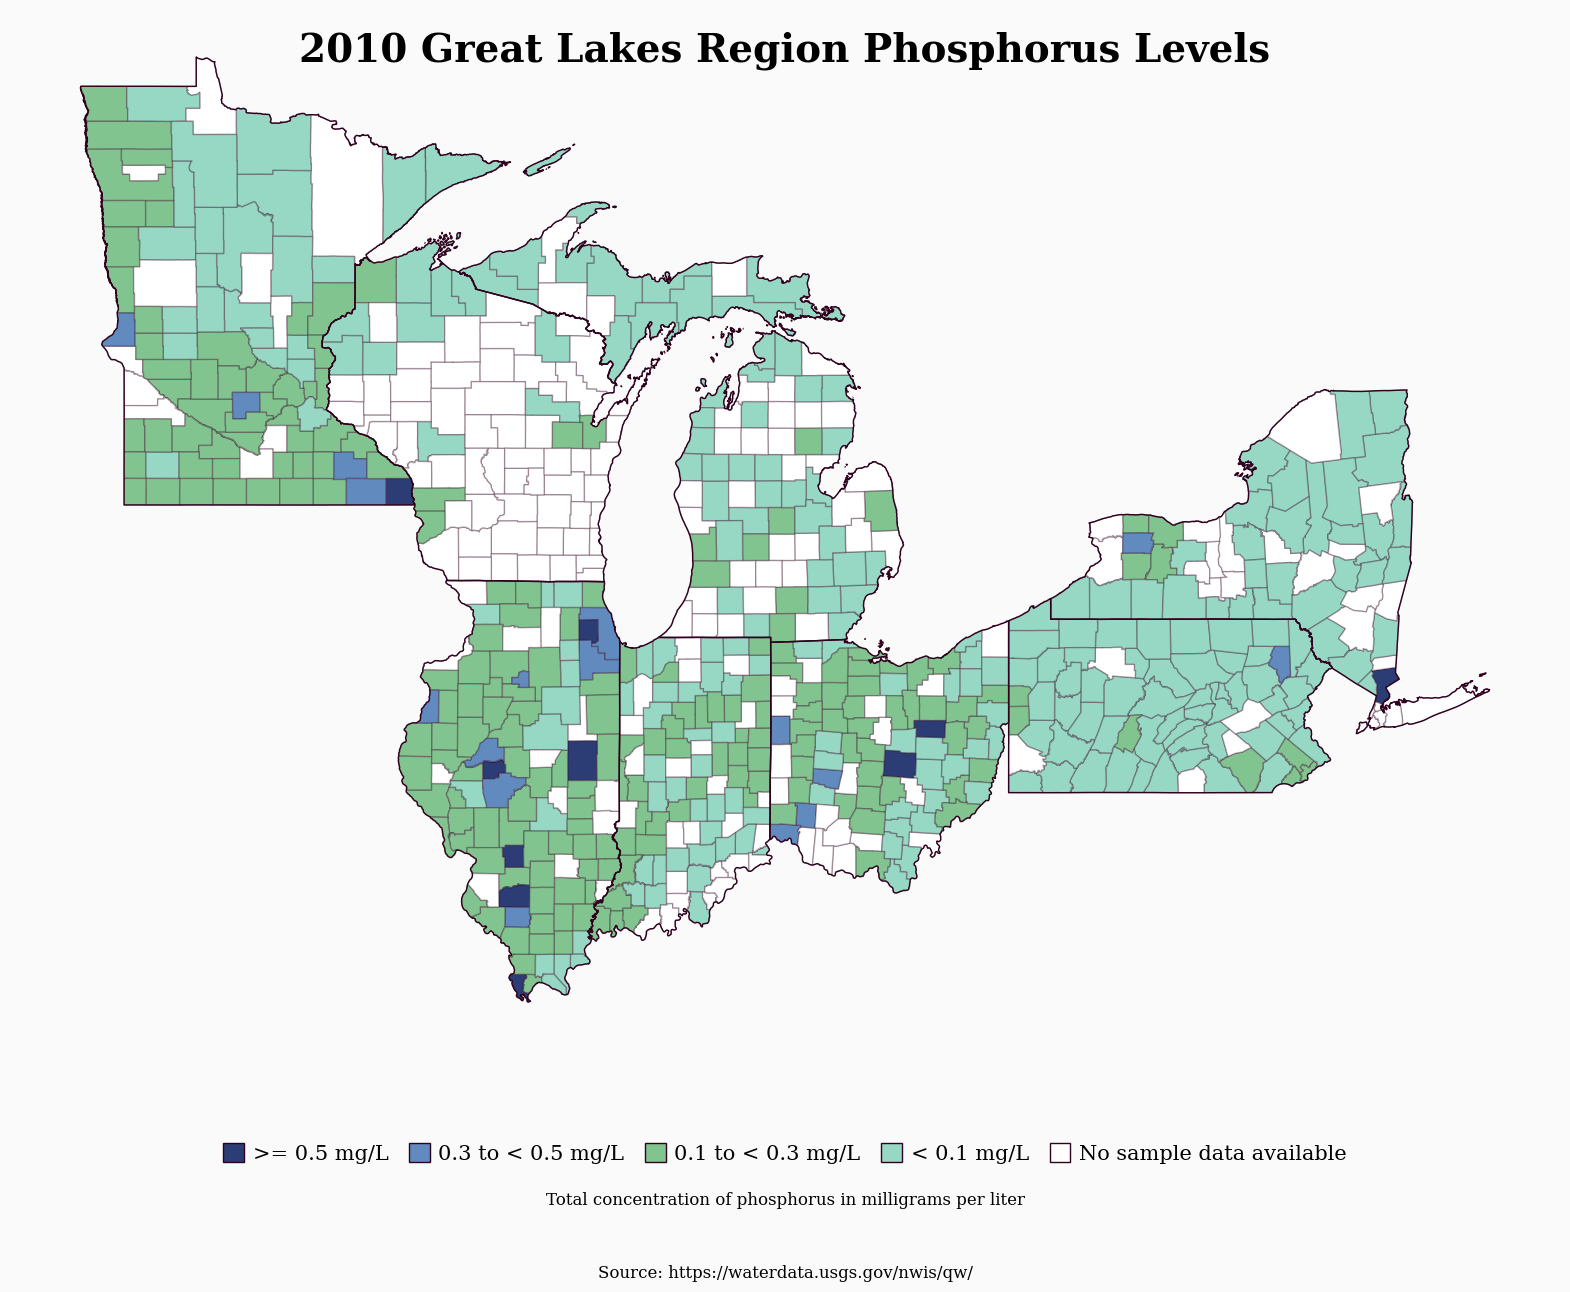

In [592]:
# Create Great Lakes phosphorus level map for 2010
create_map(usgs_GL_final, 2010, county_df, states_df)

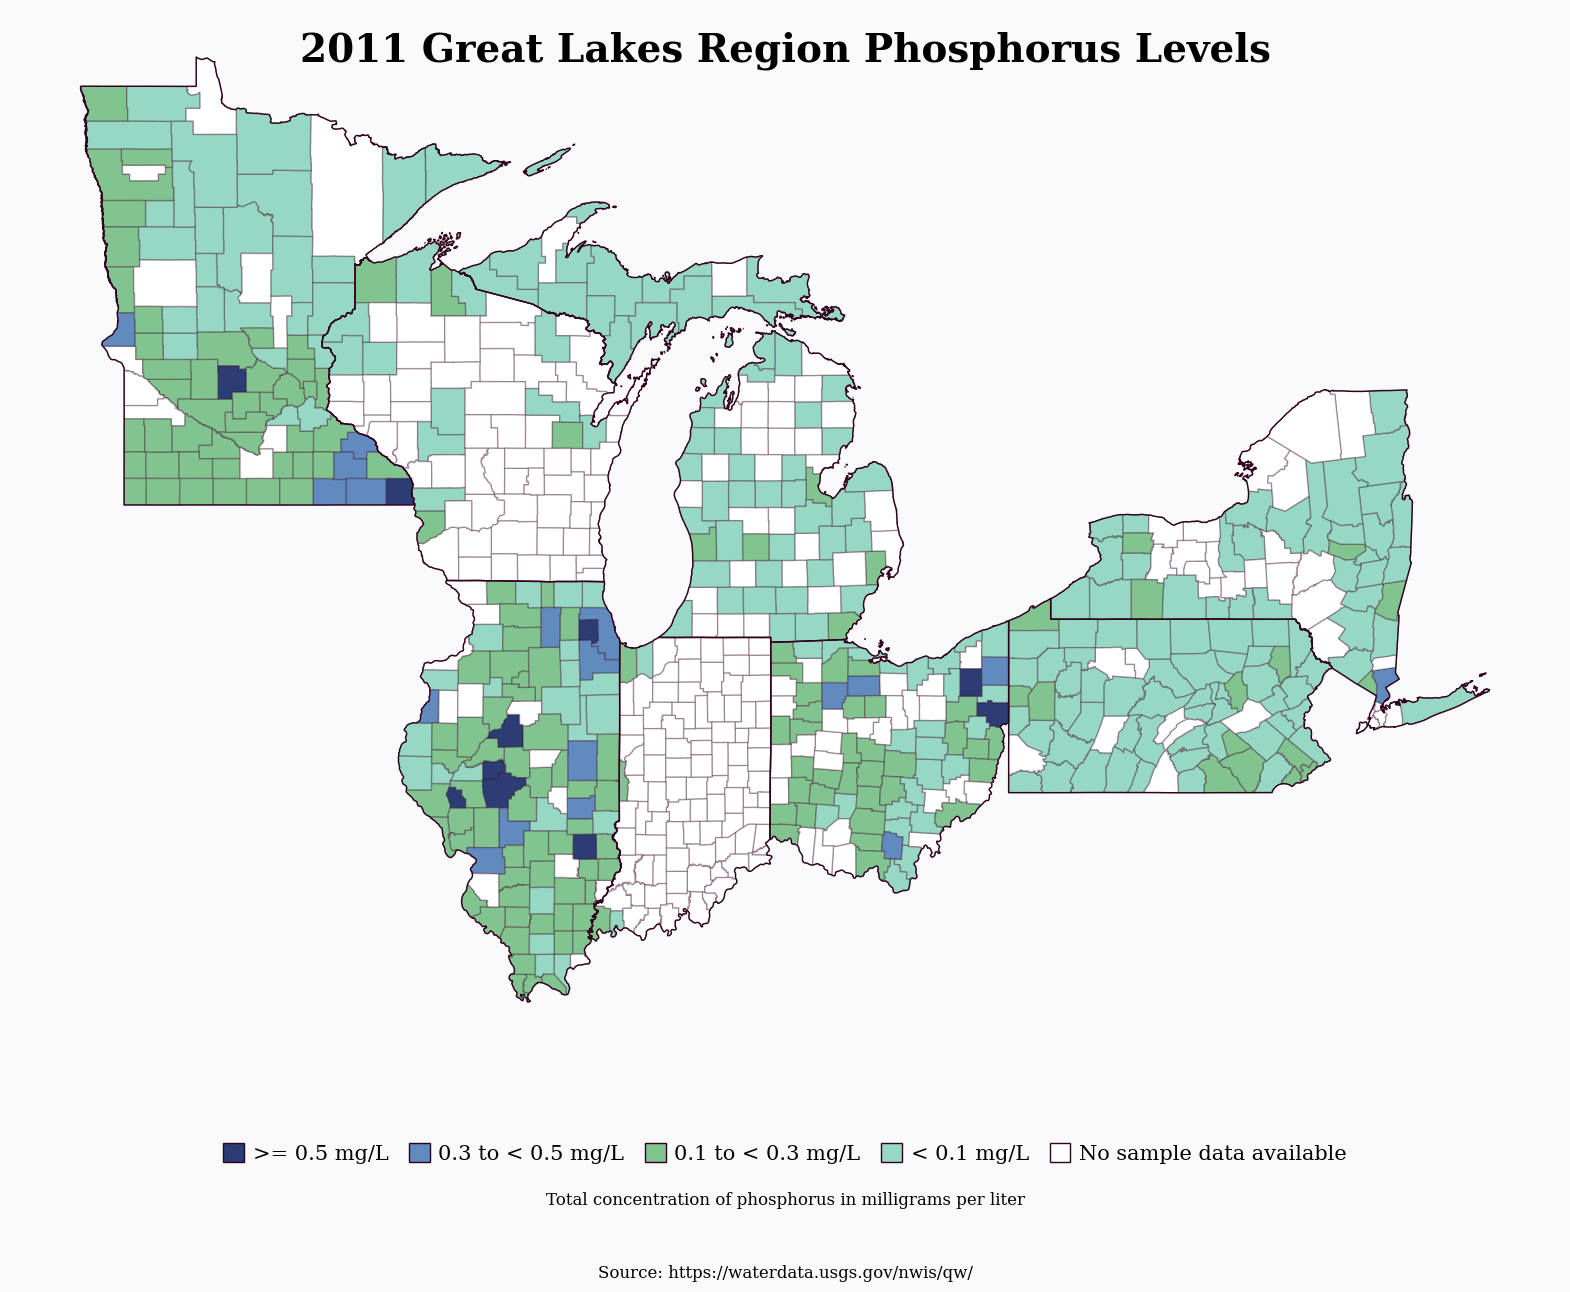

In [593]:
# Create Great Lakes phosphorus level map for 2011
create_map(usgs_GL_final, 2011, county_df, states_df)

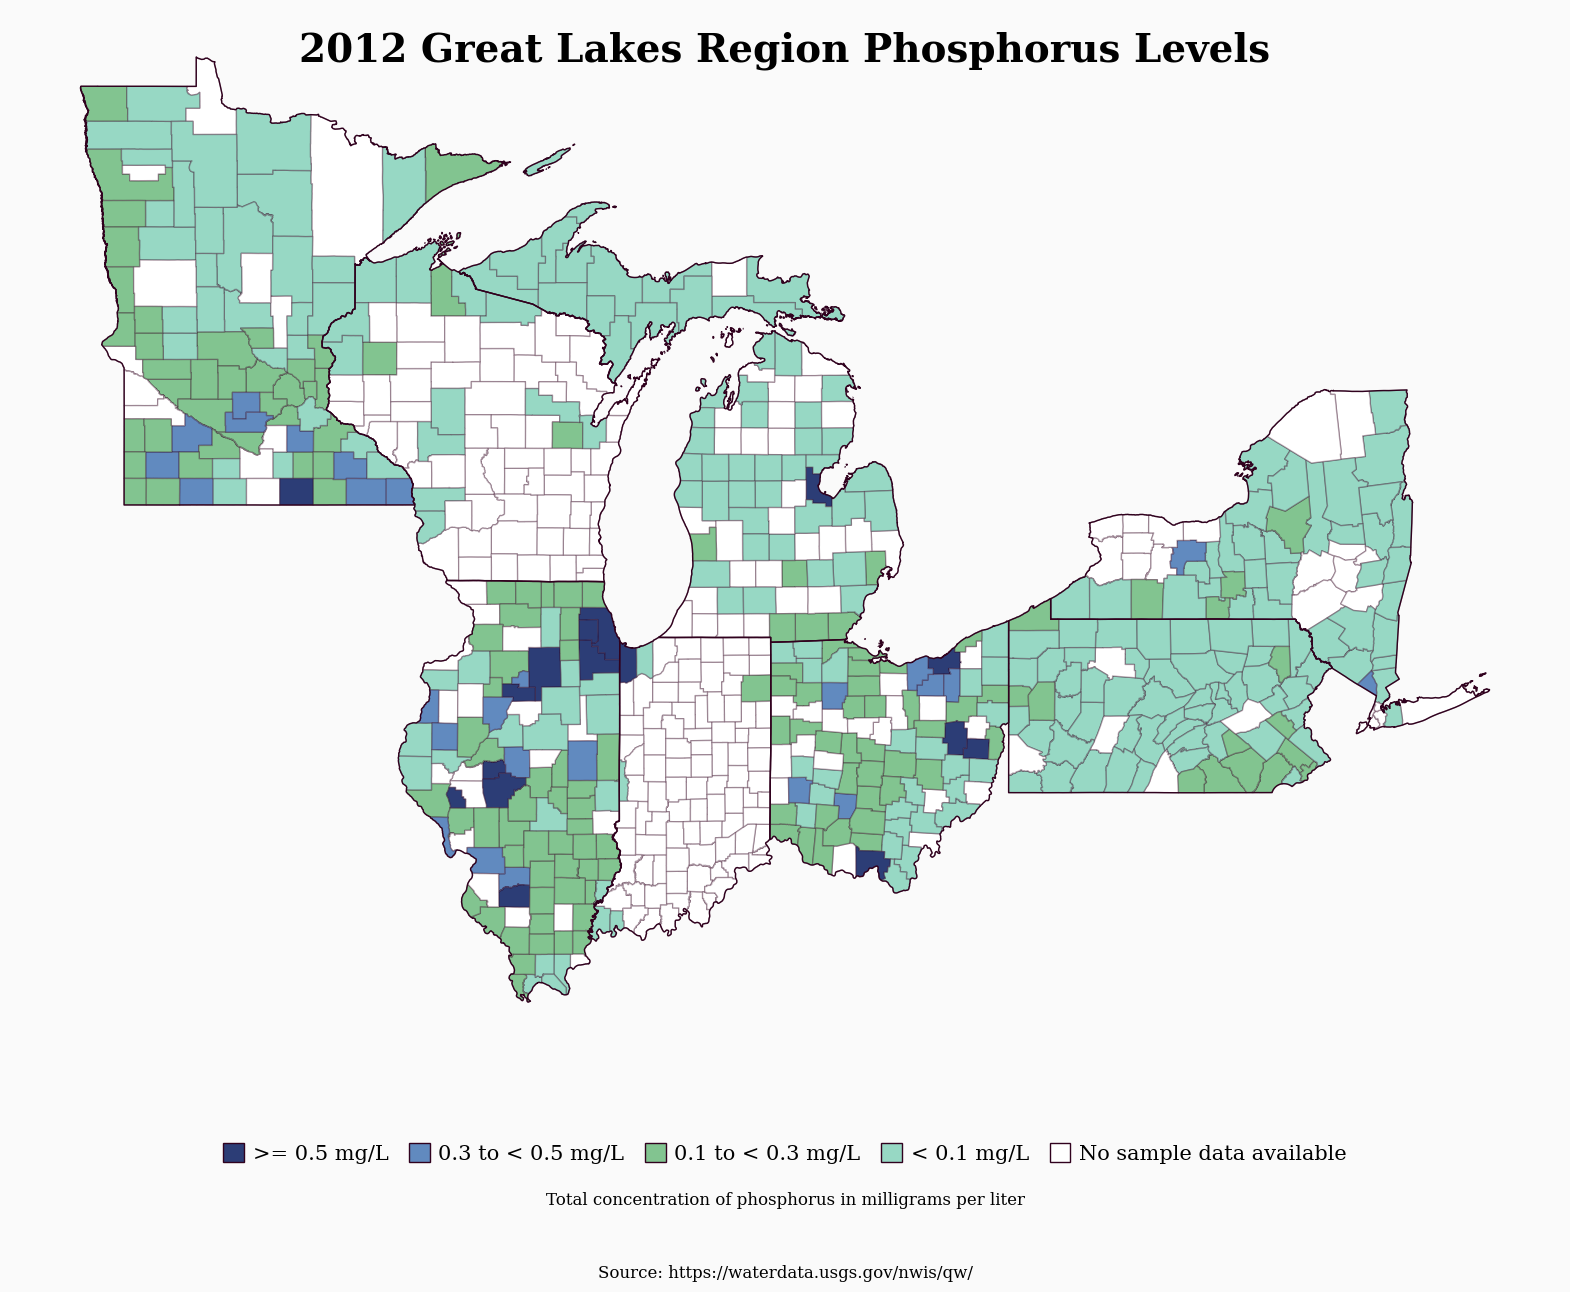

In [595]:
# Create Great Lakes phosphorus level map for 2012
create_map(usgs_GL_final, 2012, county_df, states_df)

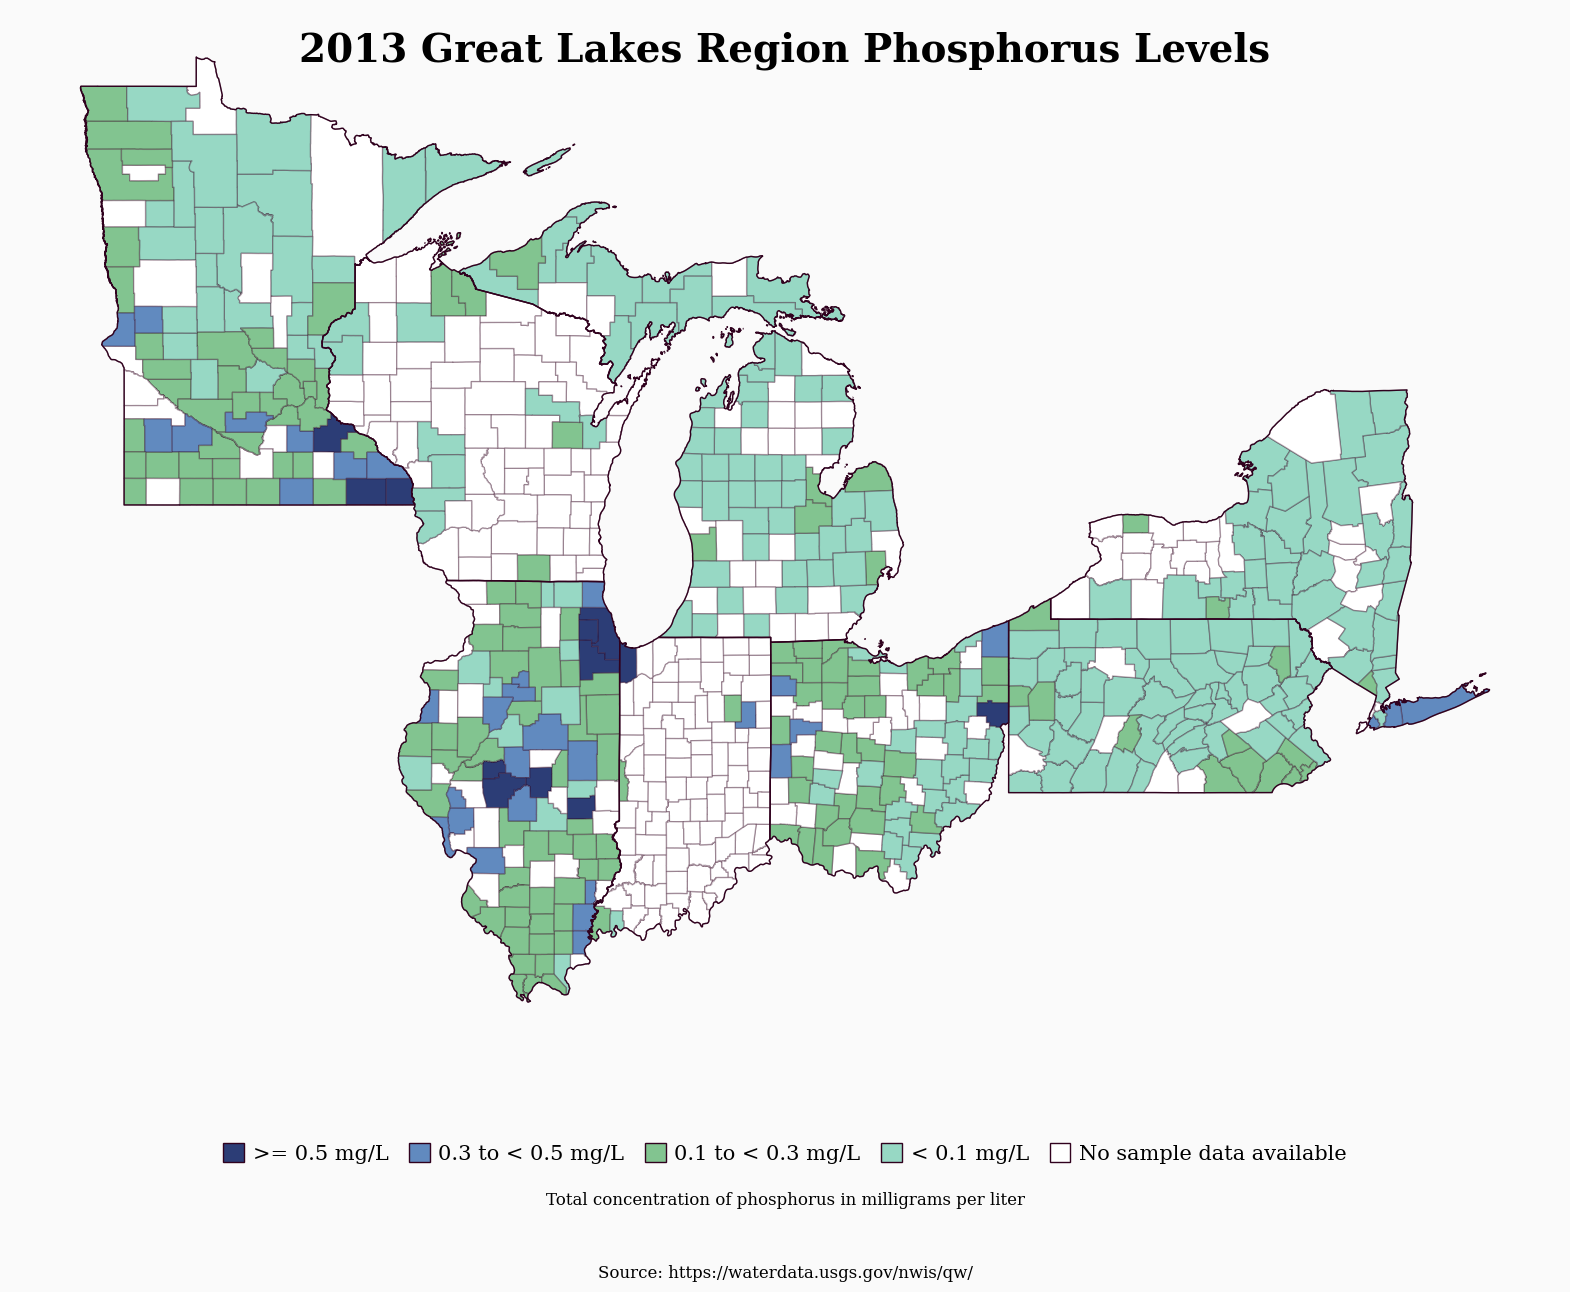

In [597]:
# Create Great Lakes phosphorus level map for 2013
create_map(usgs_GL_final, 2013, county_df, states_df)

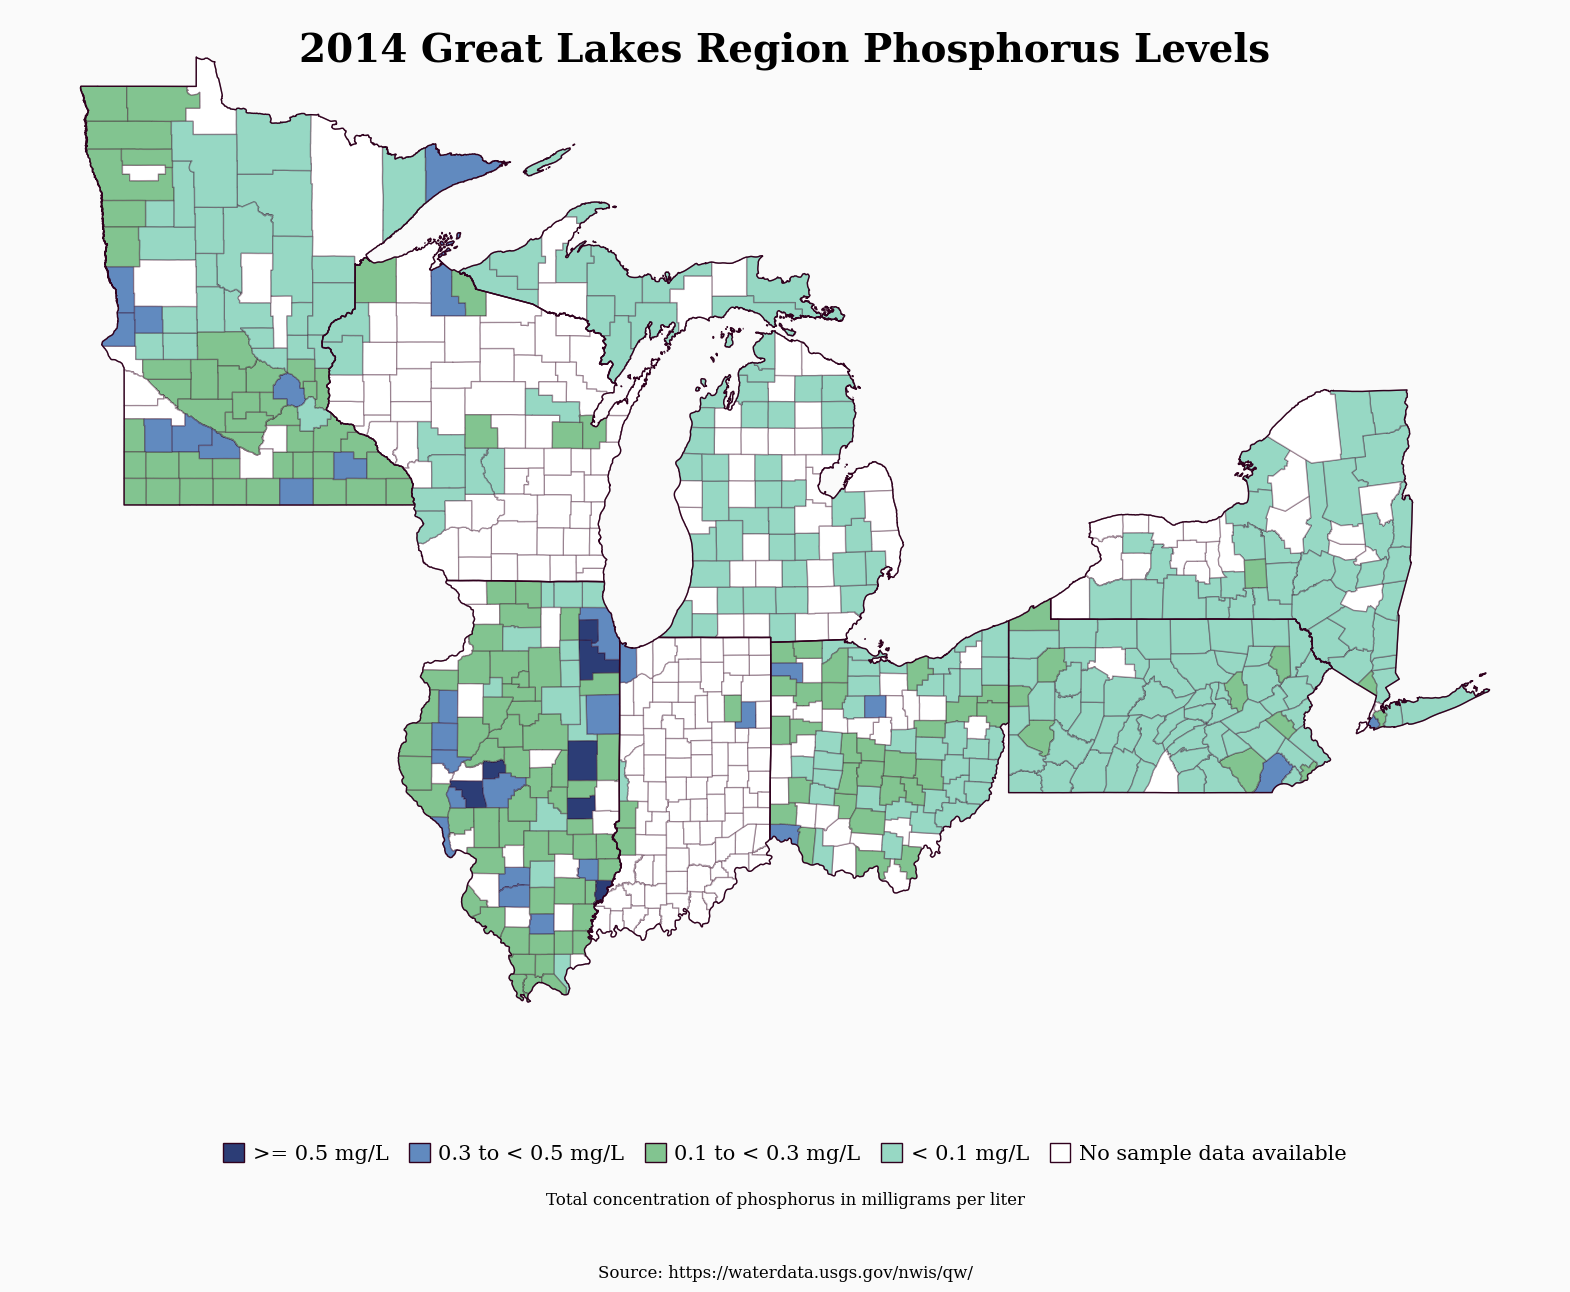

In [598]:
# Create Great Lakes phosphorus level map for 2014
create_map(usgs_GL_final, 2014, county_df, states_df)

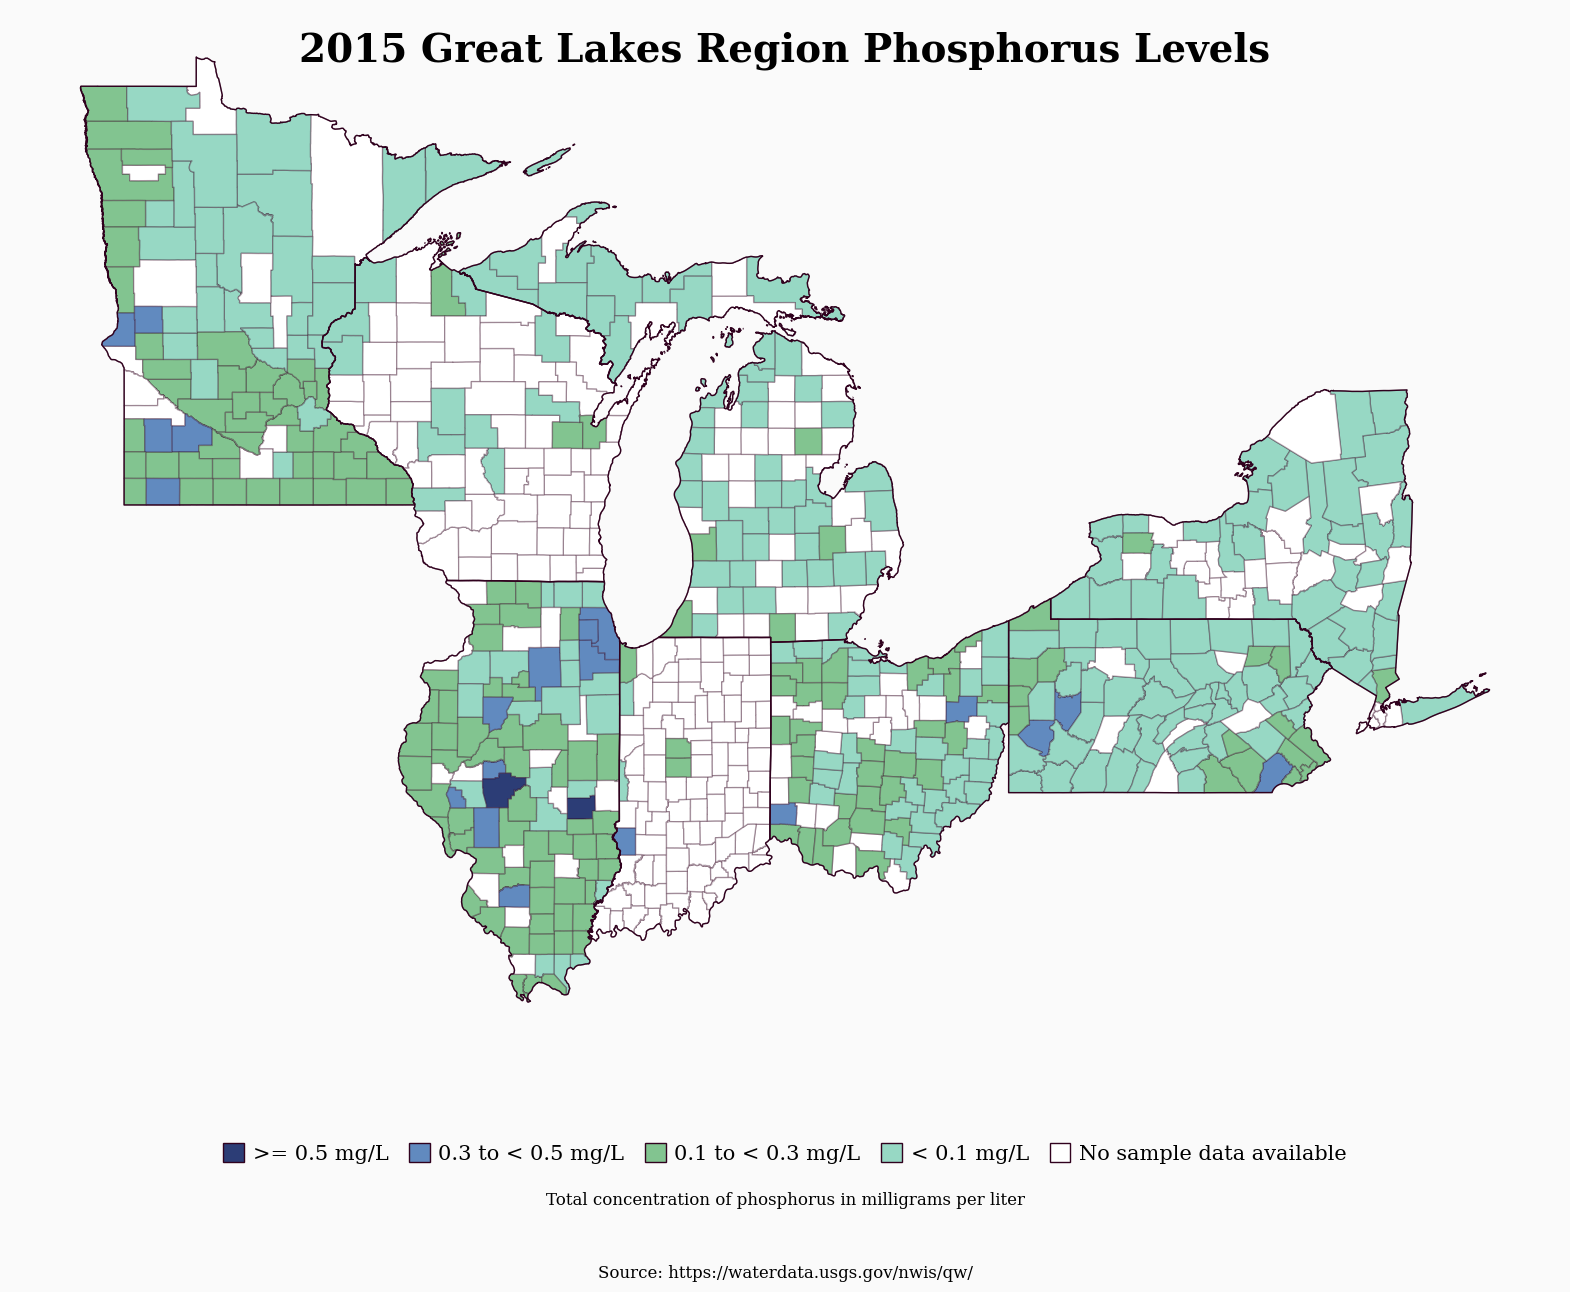

In [599]:
# Create Great Lakes phosphorus level map for 2015
create_map(usgs_GL_final, 2015, county_df, states_df)

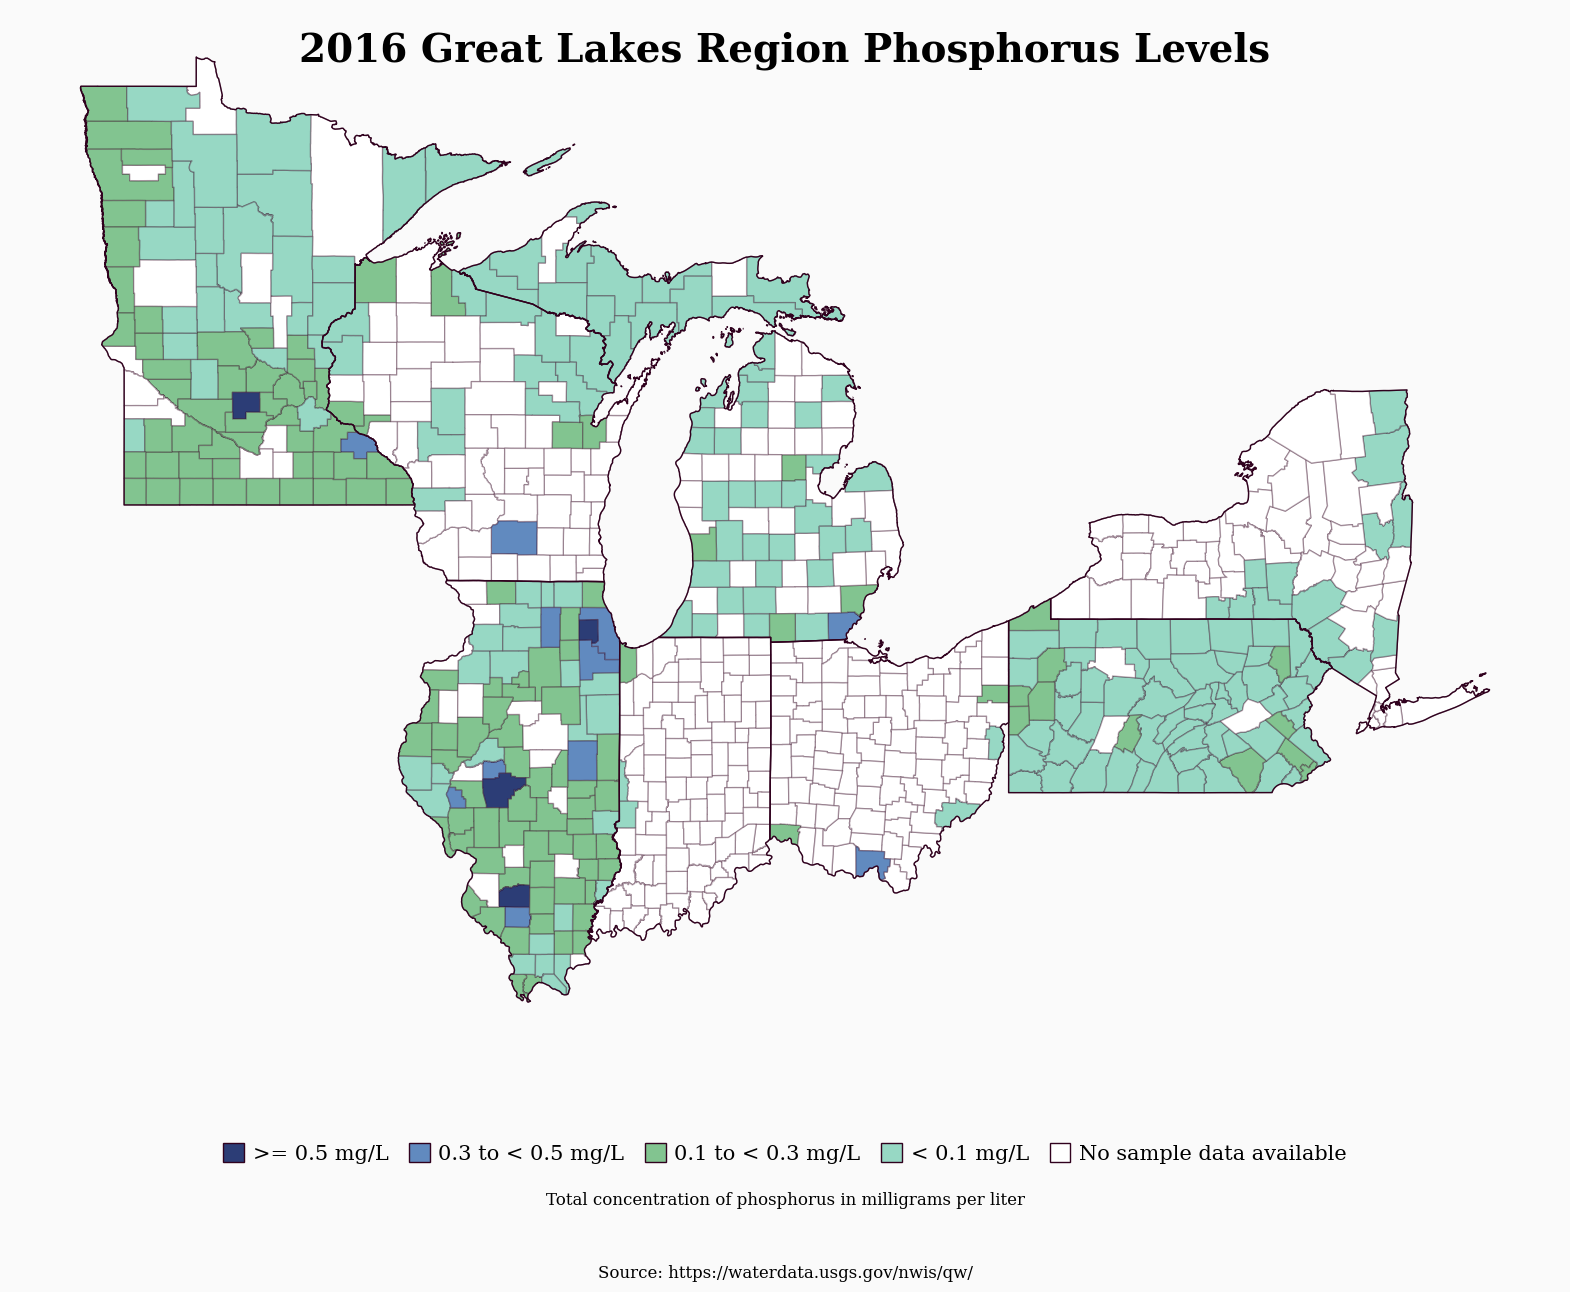

In [600]:
# Create Great Lakes phosphorus level map for 2016
create_map(usgs_GL_final, 2016, county_df, states_df)

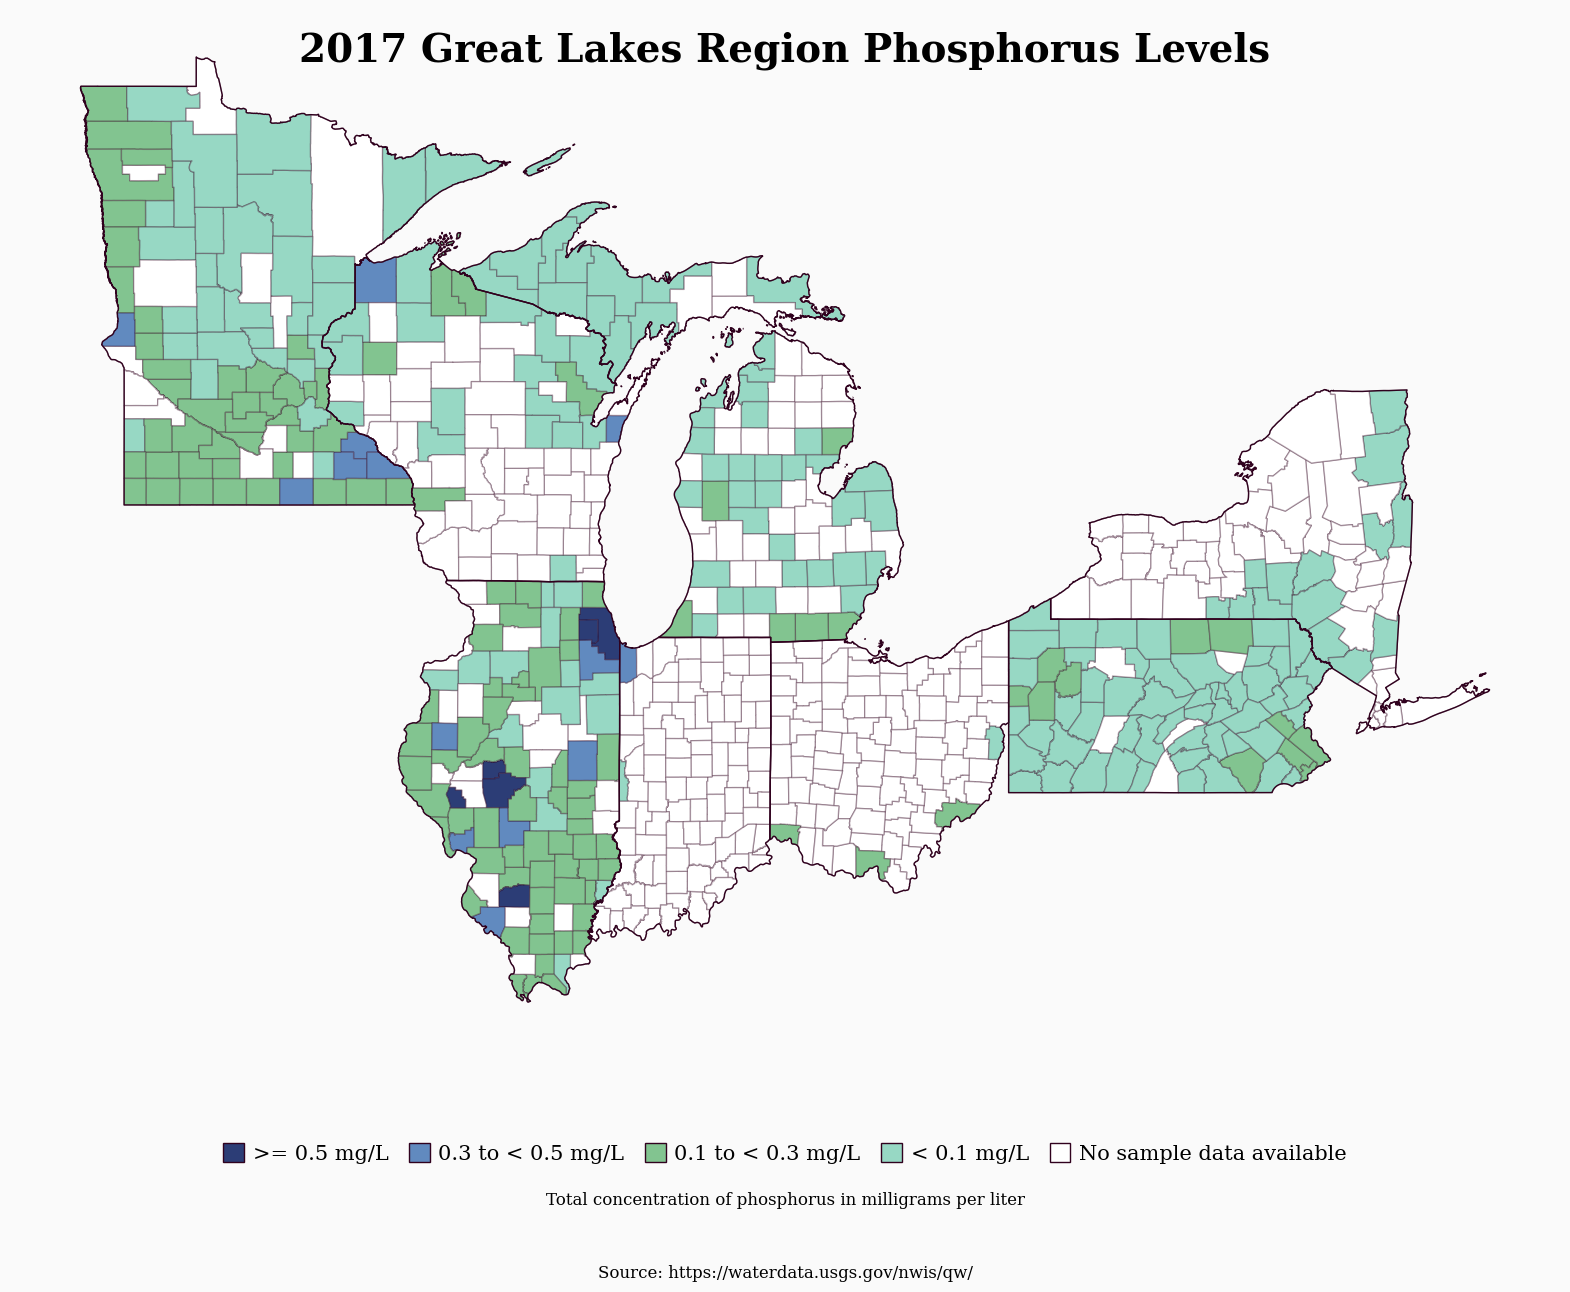

In [601]:
# Create Great Lakes phosphorus level map for 2017
create_map(usgs_GL_final, 2017, county_df, states_df)

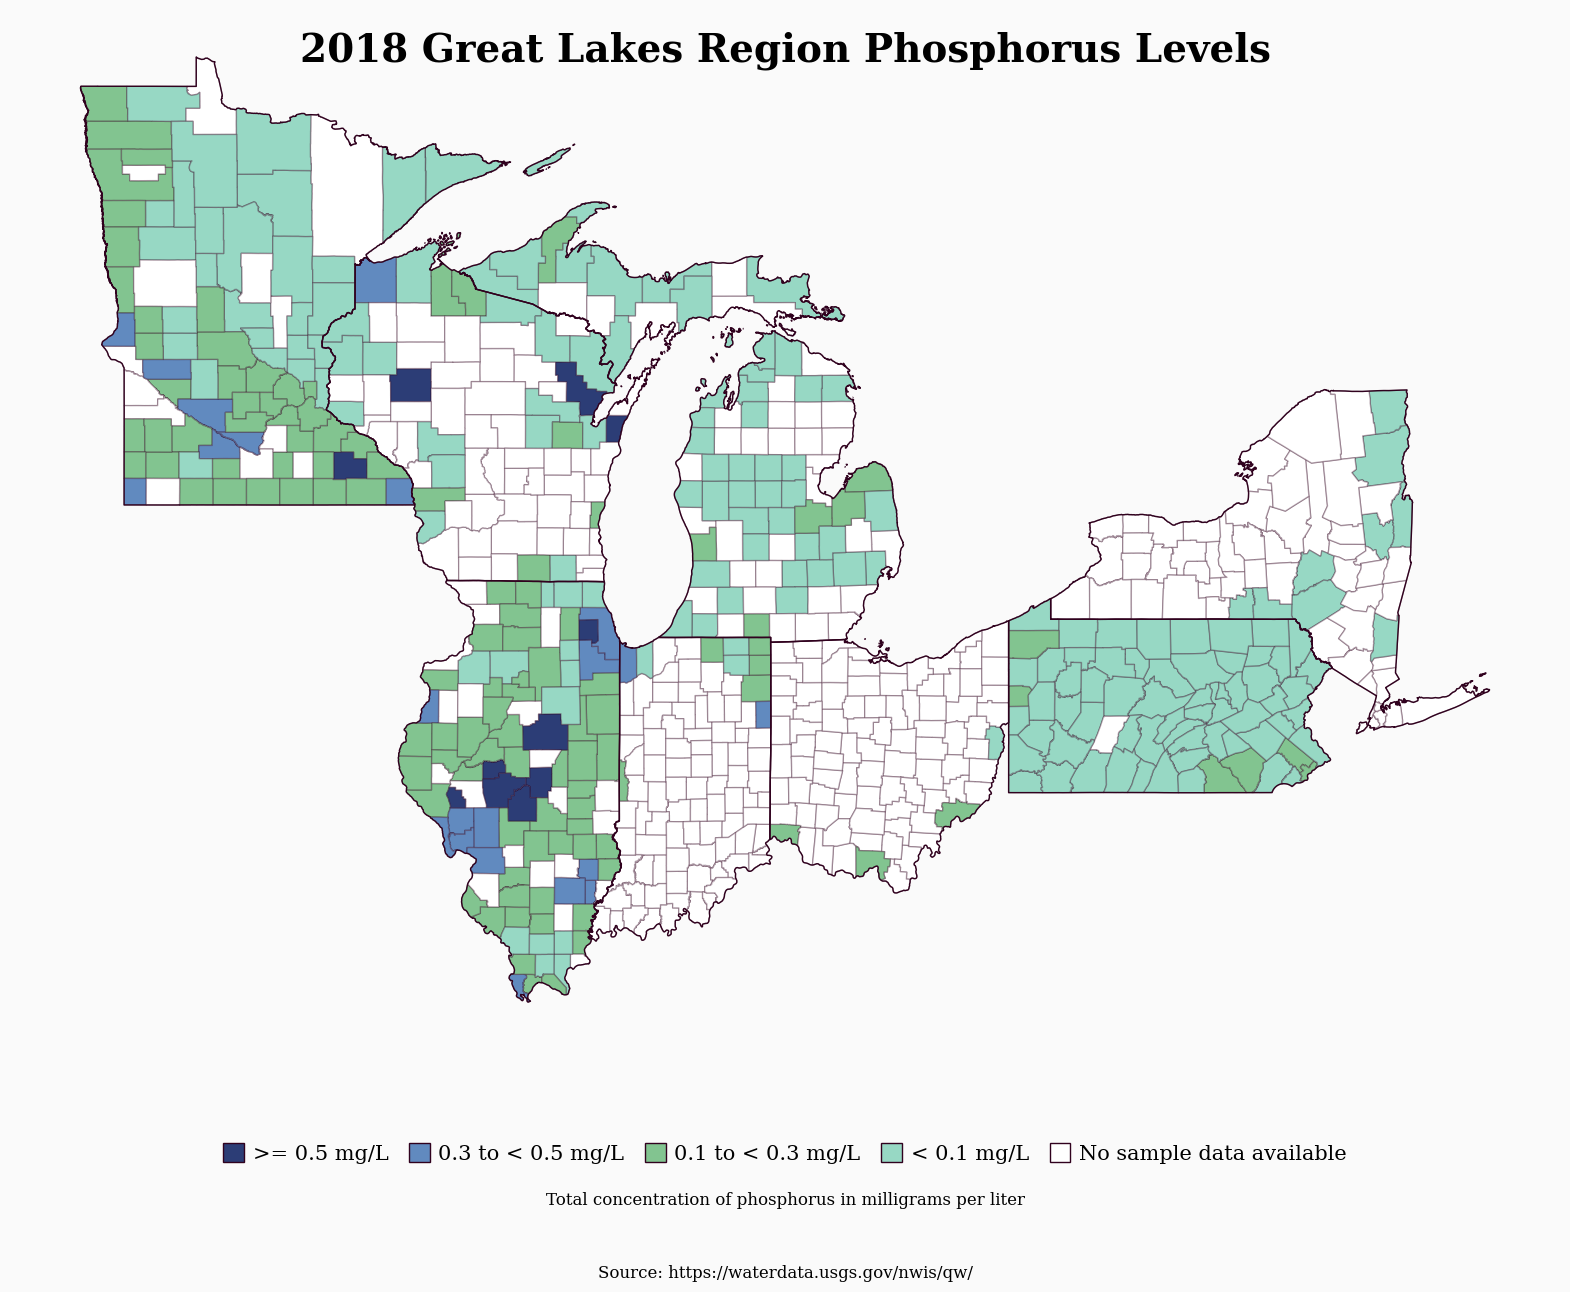

In [602]:
# Create Great Lakes phosphorus level map for 2018
create_map(usgs_GL_final, 2018, county_df, states_df)

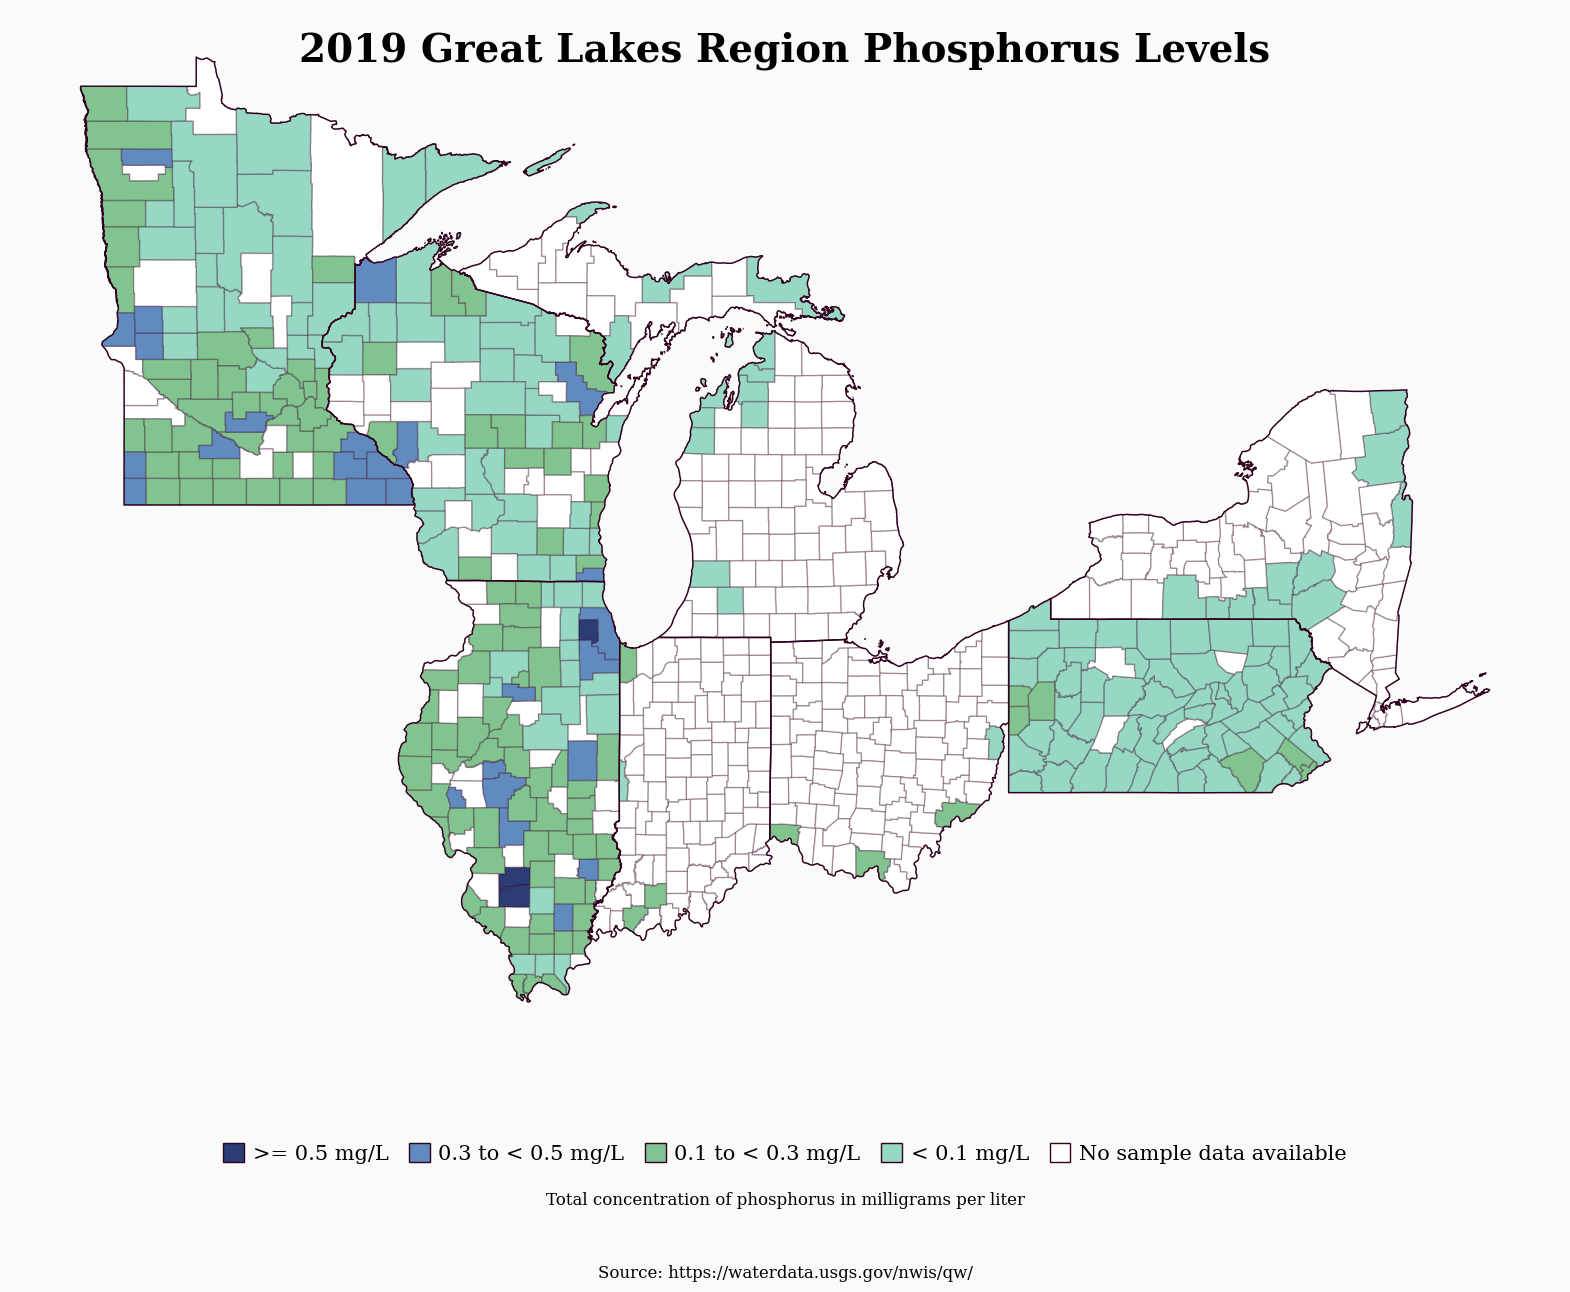

In [603]:
# Create Great Lakes phosphorus level map for 2019
create_map(usgs_GL_final, 2019, county_df, states_df)

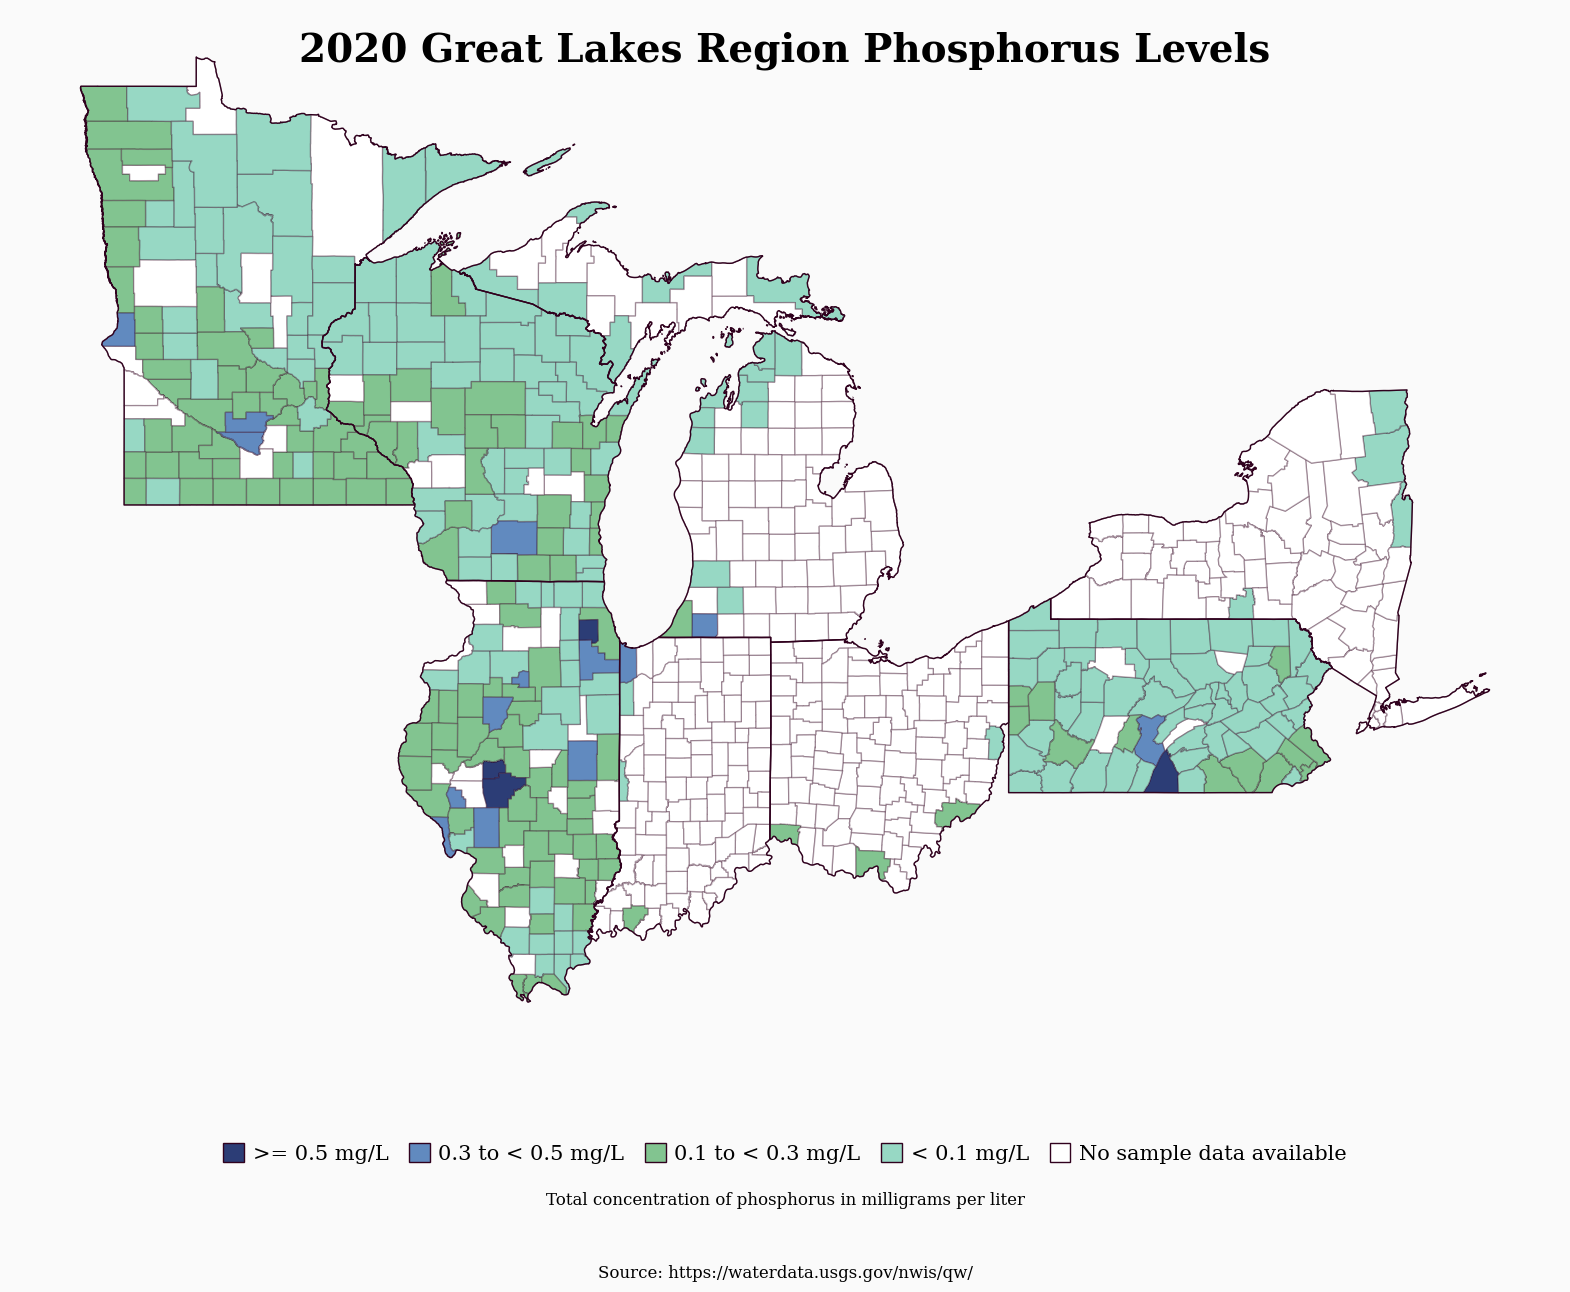

In [604]:
# Create Great Lakes phosphorus level map for 2020
create_map(usgs_GL_final, 2020, county_df, states_df)

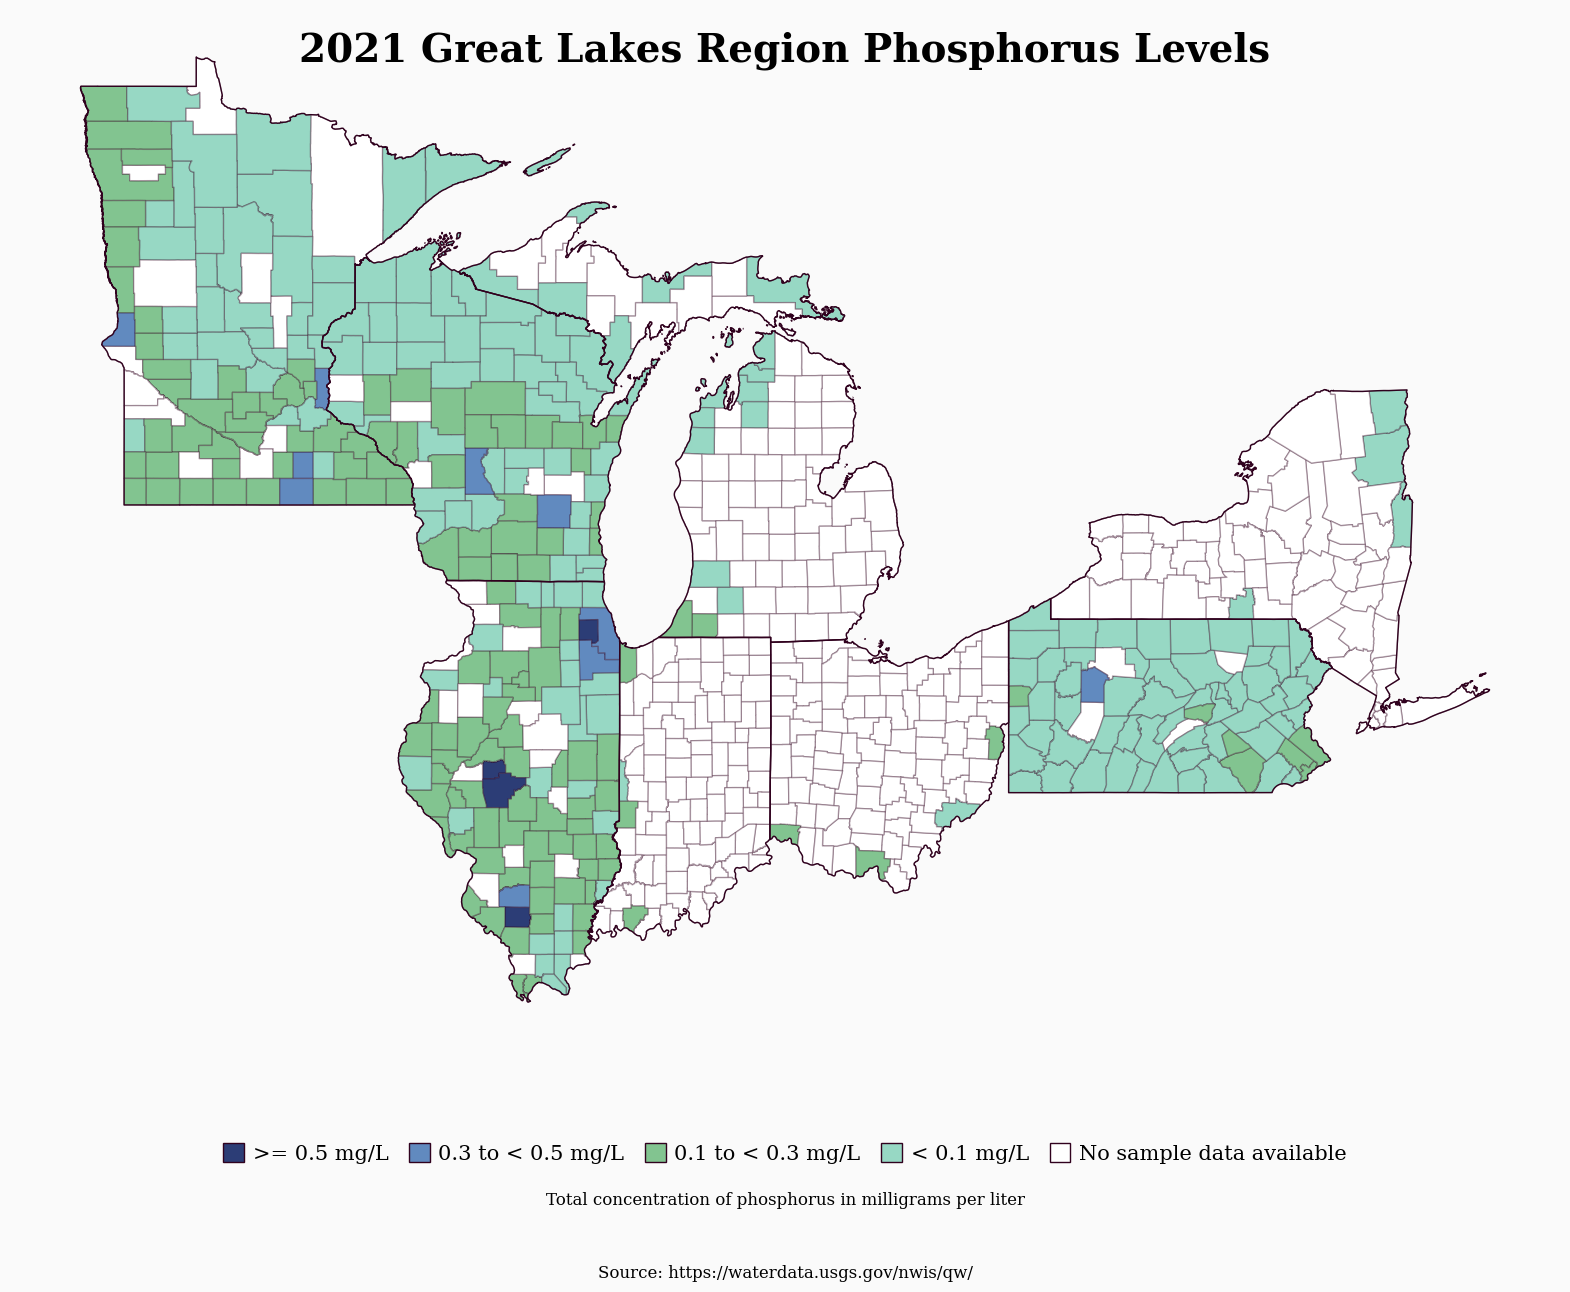

In [605]:
# Create Great Lakes phosphorus level map for 2021
create_map(usgs_GL_final, 2021, county_df, states_df)

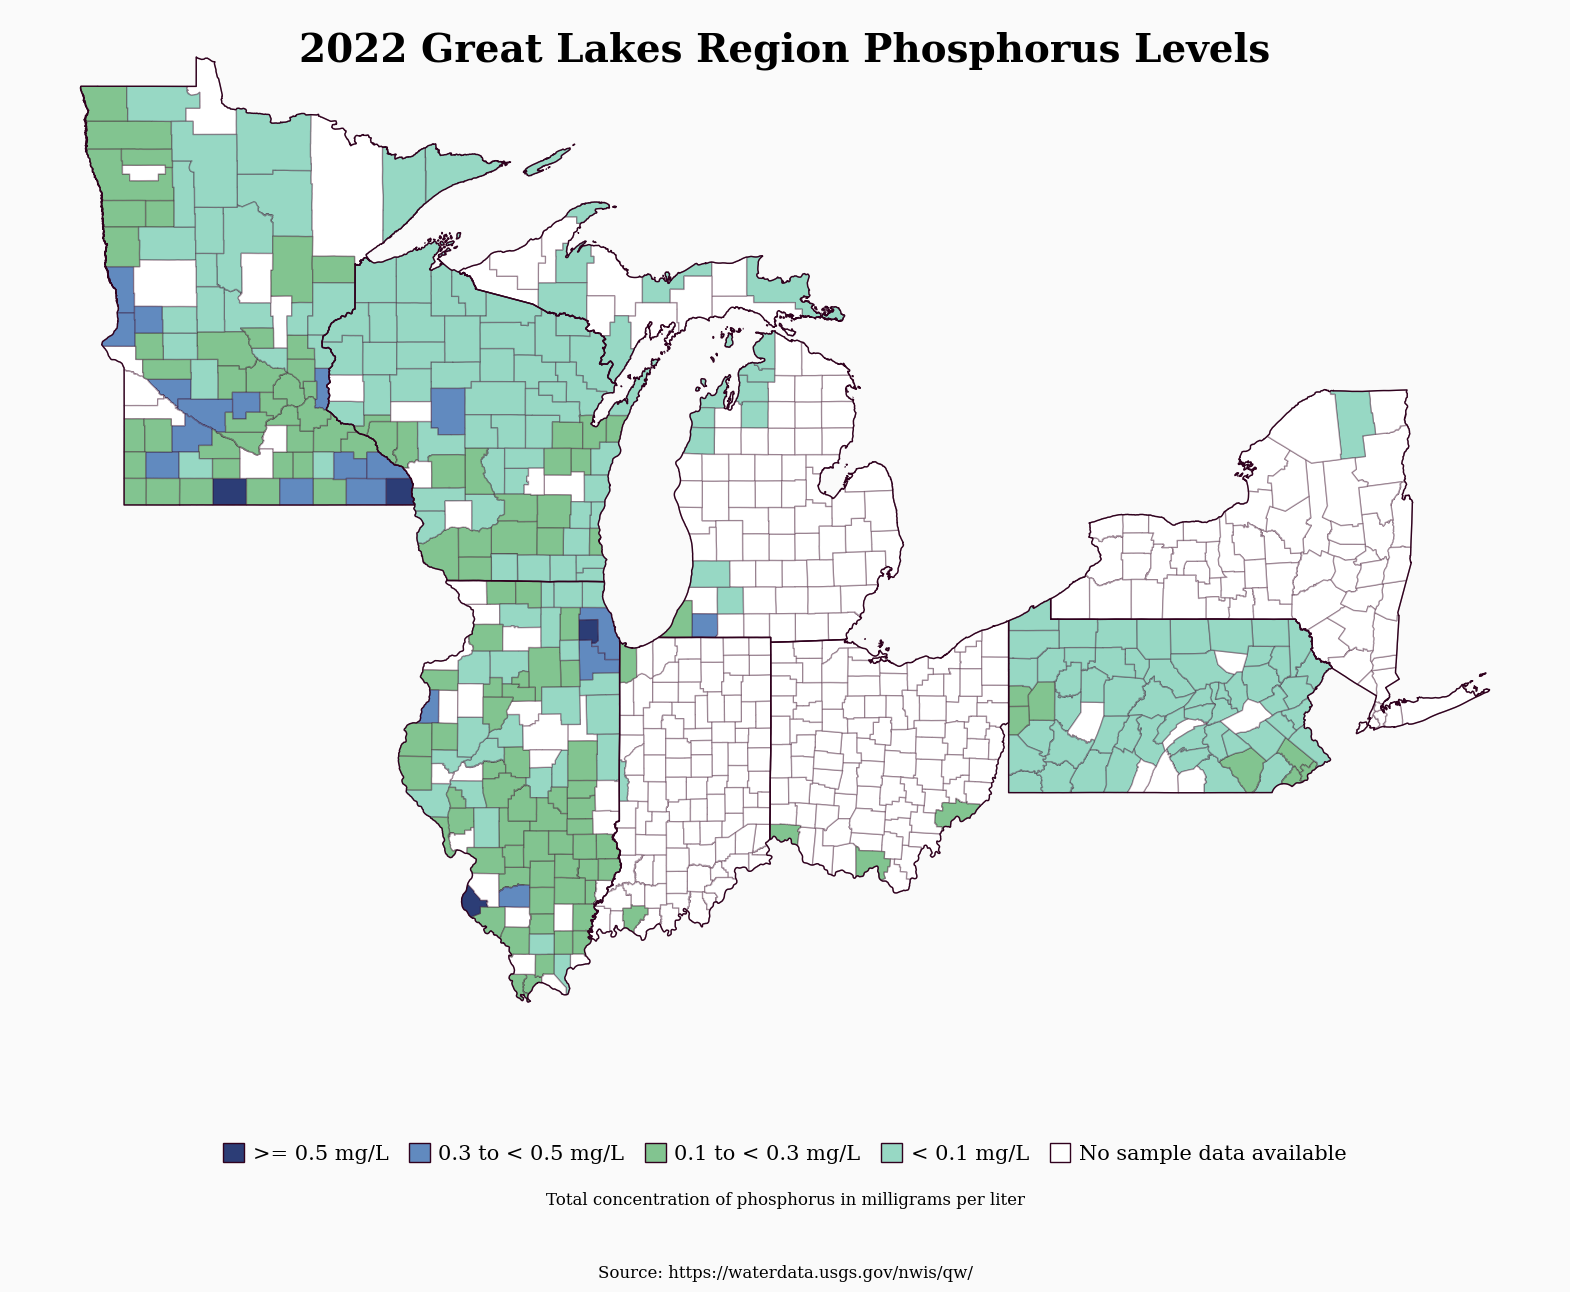

In [606]:
# Create Great Lakes phosphorus level map for 2022
create_map(usgs_GL_final, 2022, county_df, states_df)

### Generate point map of all Great Lakes sampling sites

In [619]:
# Define point_plot_add_title function
def point_plot_add_title():
    """
    Add title to point plot map
    """
    plt.annotate(
        text=f"USGS Water Quality Phosphorus Sampling Sites",
        xy=(0.5, 0.95), xycoords="axes fraction", fontsize=25, ha="center",
        fontweight="bold"
    )

In [628]:
# Define create_point_map
def create_point_map(dataframe, county_df, states_df):
    """
    Generate point map of Great Lakes region with sampling sites

    Parameters
        dataframe:
        county_df:
        states_df:
    """
    # Plot county outlines
    ax = county_df.plot(edgecolor='grey', color='none', figsize=(20, 20))

    # Plot state outlines
    states_df.plot(ax=ax, edgecolor='black', color='none', linewidth=1)

    # Plot latitude and longitude sample points within counties
    ax.scatter(dataframe['ActivityLocation/LongitudeMeasure'], dataframe['ActivityLocation/LatitudeMeasure'], color='blue', s=5)

    # ax.set_title('USGS Water Quality Phosphorus Sampling Sites')
    point_plot_add_title()
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longtitude')

    plt.show()

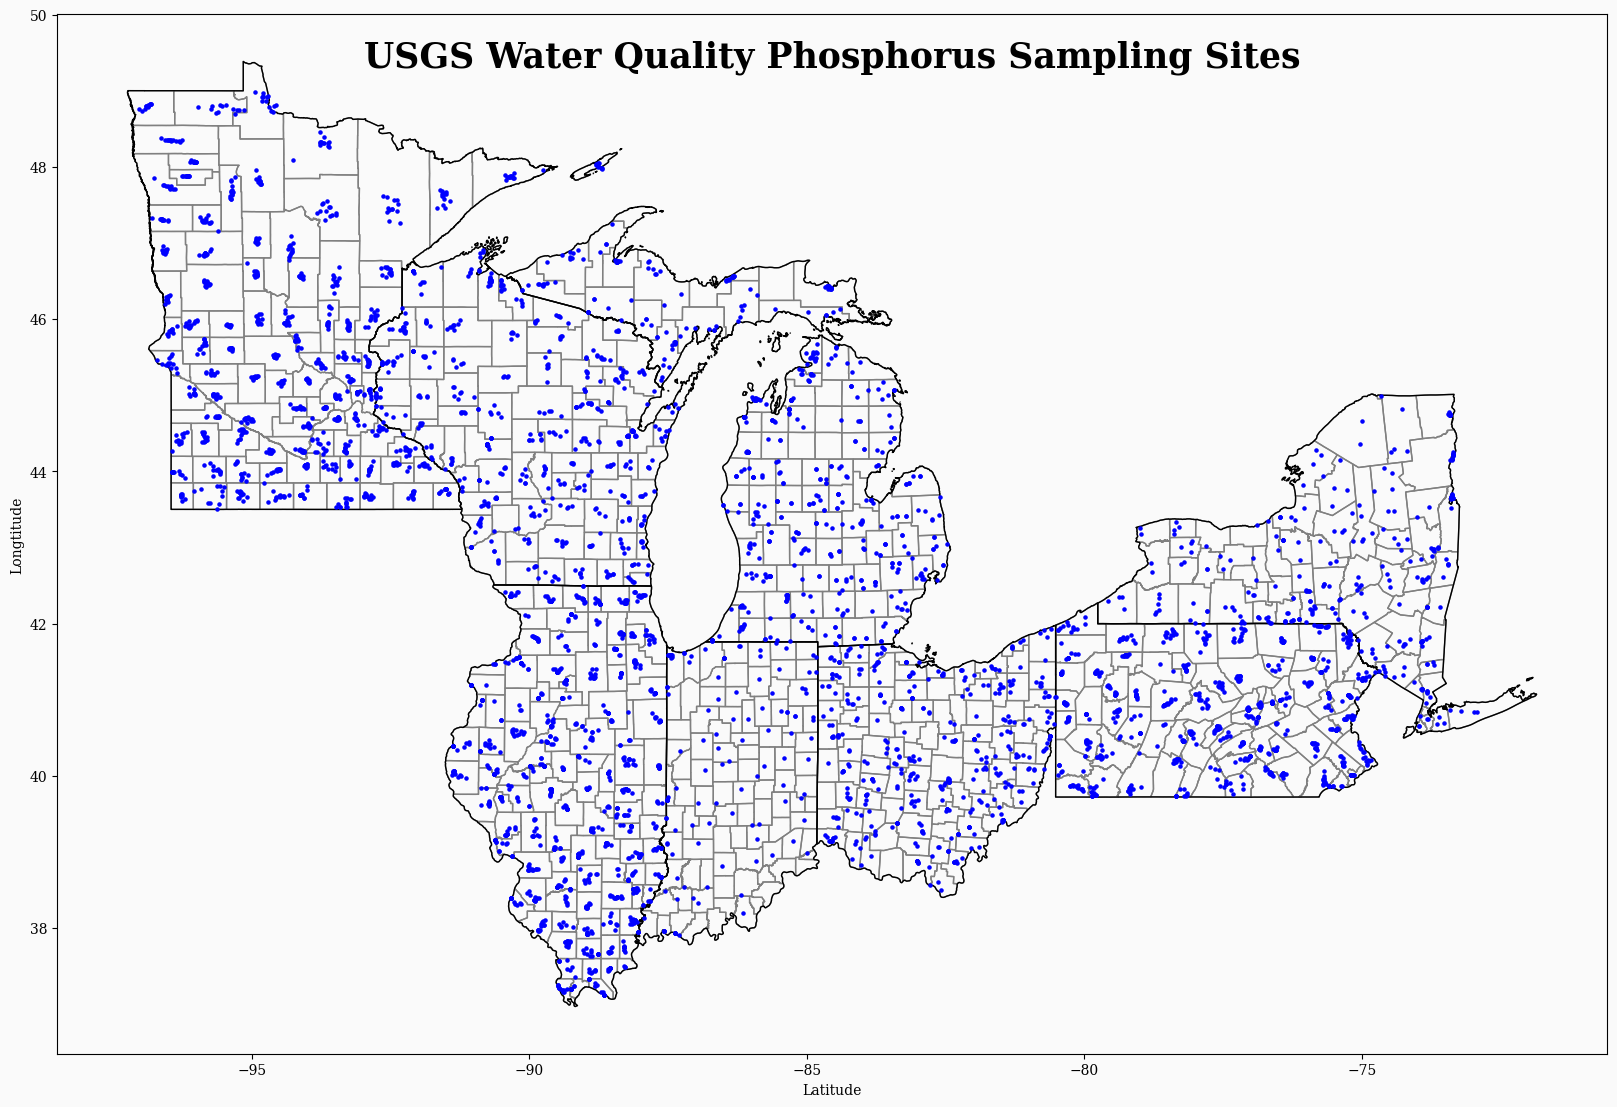

In [629]:
# Generate point plot of all Great Lakes sampling sites
create_point_map(usgs_GL_final, county_df, states_df)